In [1]:
# Author: A. Wenteler

In [4]:
import pandas as pd
import biorosetta as br 
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
#perts = ['IKZF3', 'GLB1L2', 'SPI1']
perts = ['GLB1L2']
models = ['raw_expression', 'geneformer', 'scgpt', 'uce', 'scfoundation', 'scbert']

In [59]:
# Load the data
base = '../../data/splits/perturb/norman/'
base_path = f'{base}pert_effects/' 

In [60]:
data = {model: {pert: {} for pert in perts} for model in models}

for model in models:
    for pert in perts:
        try:
            pred_path = f'{base_path}{pert}/pert_effect_pred_{model}.pkl'
            target_path = f'{base_path}{pert}/pert_effect_target_{model}.pkl'
            data[model][pert]['pred'] = pd.read_pickle(pred_path).numpy()
            data[model][pert]['target'] = pd.read_pickle(target_path).numpy()
        except FileNotFoundError:
            print(f"Data not found for {model} - {pert}")

Data not found for geneformer - GLB1L2
Data not found for scgpt - GLB1L2
Data not found for uce - GLB1L2
Data not found for scfoundation - GLB1L2
Data not found for scbert - GLB1L2


In [61]:
deg_dict = pd.read_pickle(f'{base}de_test/deg_pert_dict.pkl')

In [17]:
idmap = br.IDMapper('all') 
deg_dict_symb = {}
for k, v in deg_dict.items():
    converted = idmap.convert(v, 'ensg', 'symb')
    deg_dict_symb[k] = [symb if symb != 'N/A' else ensg for ensg, symb in zip(v, converted)]

- Loading lookup tables from cache (use function EnsemblBiomartMapper.download_data() to force new download)
- Loading lookup tables from cache (use function HGNCBiomartMapper.download_data() to force new download)


In [62]:
model_names = {
    'raw_expression': 'Raw expression',
    'scgpt': 'scGPT',
    'scbert': 'scBERT',
    'scfoundation': 'scFoundation',
    'uce': 'UCE',
    'geneformer': 'Geneformer'
}
model_colors = pd.read_pickle(f'model_colors.pkl')
model_colors_dict = {
    'Raw expression': model_colors[4],
    'scBERT': model_colors[1],
    'UCE': model_colors[2],
    'Geneformer': model_colors[3],
    'scGPT': model_colors[6],
    'scFoundation': model_colors[5]
}
model_colors_dict

{'Raw expression': (0.03529411764705882,
  0.596078431372549,
  0.611764705882353,
  1.0),
 'scBERT': (0.9921568627450981, 0.6588235294117647, 0.0196078431372549, 1.0),
 'UCE': (0.6941176470588235, 0.792156862745098, 0.0196078431372549, 1.0),
 'Geneformer': (0.4666666666666667,
  0.596078431372549,
  0.08235294117647059,
  1.0),
 'scGPT': (0.49411764705882355, 0.16862745098039217, 0.5568627450980392, 1.0),
 'scFoundation': (0.24705882352941178,
  0.39215686274509803,
  0.807843137254902,
  1.0)}

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_swarm_plots(data, deg_dict_symb, variance_threshold=0.01, effect_threshold=0.1):
    for pert in data['raw_expression']:
        # Get the differentially expressed genes for this perturbation
        deg_genes = deg_dict_symb.get(pert, [])

        # Extract the target gene expression data
        target = data['raw_expression'][pert]['target']

        # Create a DataFrame for the target
        df_target = pd.DataFrame(target, columns=deg_genes)

        # Calculate variance and absolute mean effect for each gene
        gene_variances = df_target.var()
        gene_effects = df_target.abs().mean()

        # Filter genes based on variance and effect size
        genes_to_keep = (gene_variances > variance_threshold) & (gene_effects > effect_threshold)
        df_target_filtered = df_target.loc[:, genes_to_keep]

        # If no genes pass the filter, skip this plot
        if df_target_filtered.empty:
            print(f"No genes pass the filter for {pert}")
            continue

        # Calculate the absolute mean effect for each remaining gene
        gene_effects = df_target_filtered.abs().mean().sort_values(ascending=False)

        # Order the genes based on absolute effect size
        ordered_genes = gene_effects.index.tolist()

        # Reorder the DataFrame columns
        df_target_filtered = df_target_filtered[ordered_genes]

        # Calculate the mean of the target gene expression data
        target_means = df_target_filtered.mean()

        # Create a DataFrame to store mean expression for each model
        model_means = pd.DataFrame({'Gene': ordered_genes, 'Target': target_means})

        # Process data for each model
        for model in data:
            pred = data[model][pert]['pred']
            df_model = pd.DataFrame(pred, columns=deg_genes)
            df_model_filtered = df_model[ordered_genes]
            model_means[model] = df_model_filtered.mean()

        # Melt the DataFrame for seaborn
        model_means_melted = model_means.melt(id_vars='Gene', var_name='Model', value_name='Expression')

        # Create the plot
        plt.figure(figsize=(16, 8), dpi=300)

        # Plot the target means as dashed lines per gene
        for i, gene in enumerate(ordered_genes):
            plt.plot([i - 0.4, i + 0.4], [target_means[gene]] * 2, 'k--', label='Target mean' if i == 0 else "")

        # Use seaborn's swarmplot to plot the model means
        model_means_melted = model_means_melted[model_means_melted['Model'] != 'Target']
        model_means_melted['Model'] = model_means_melted['Model'].map(model_names)
        palette = {model: model_colors_dict[model] for model in model_means_melted['Model'].unique()}
        
        sns.swarmplot(data=model_means_melted, x='Gene', y='Expression', hue='Model', dodge=True, size=8, palette=palette)

        # Customize the plot
        plt.xticks(range(len(ordered_genes)), ordered_genes, rotation=45, ha='right')
        plt.xlabel('Differentially expressed genes')
        plt.ylabel('Perturbation effect (LogFC)')
        plt.legend(loc='upper right')
        
        # Disable the legend
        # plt.legend([],[], frameon=False)

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.savefig(f"paper_figs/{pert}_swarmplot.pdf")

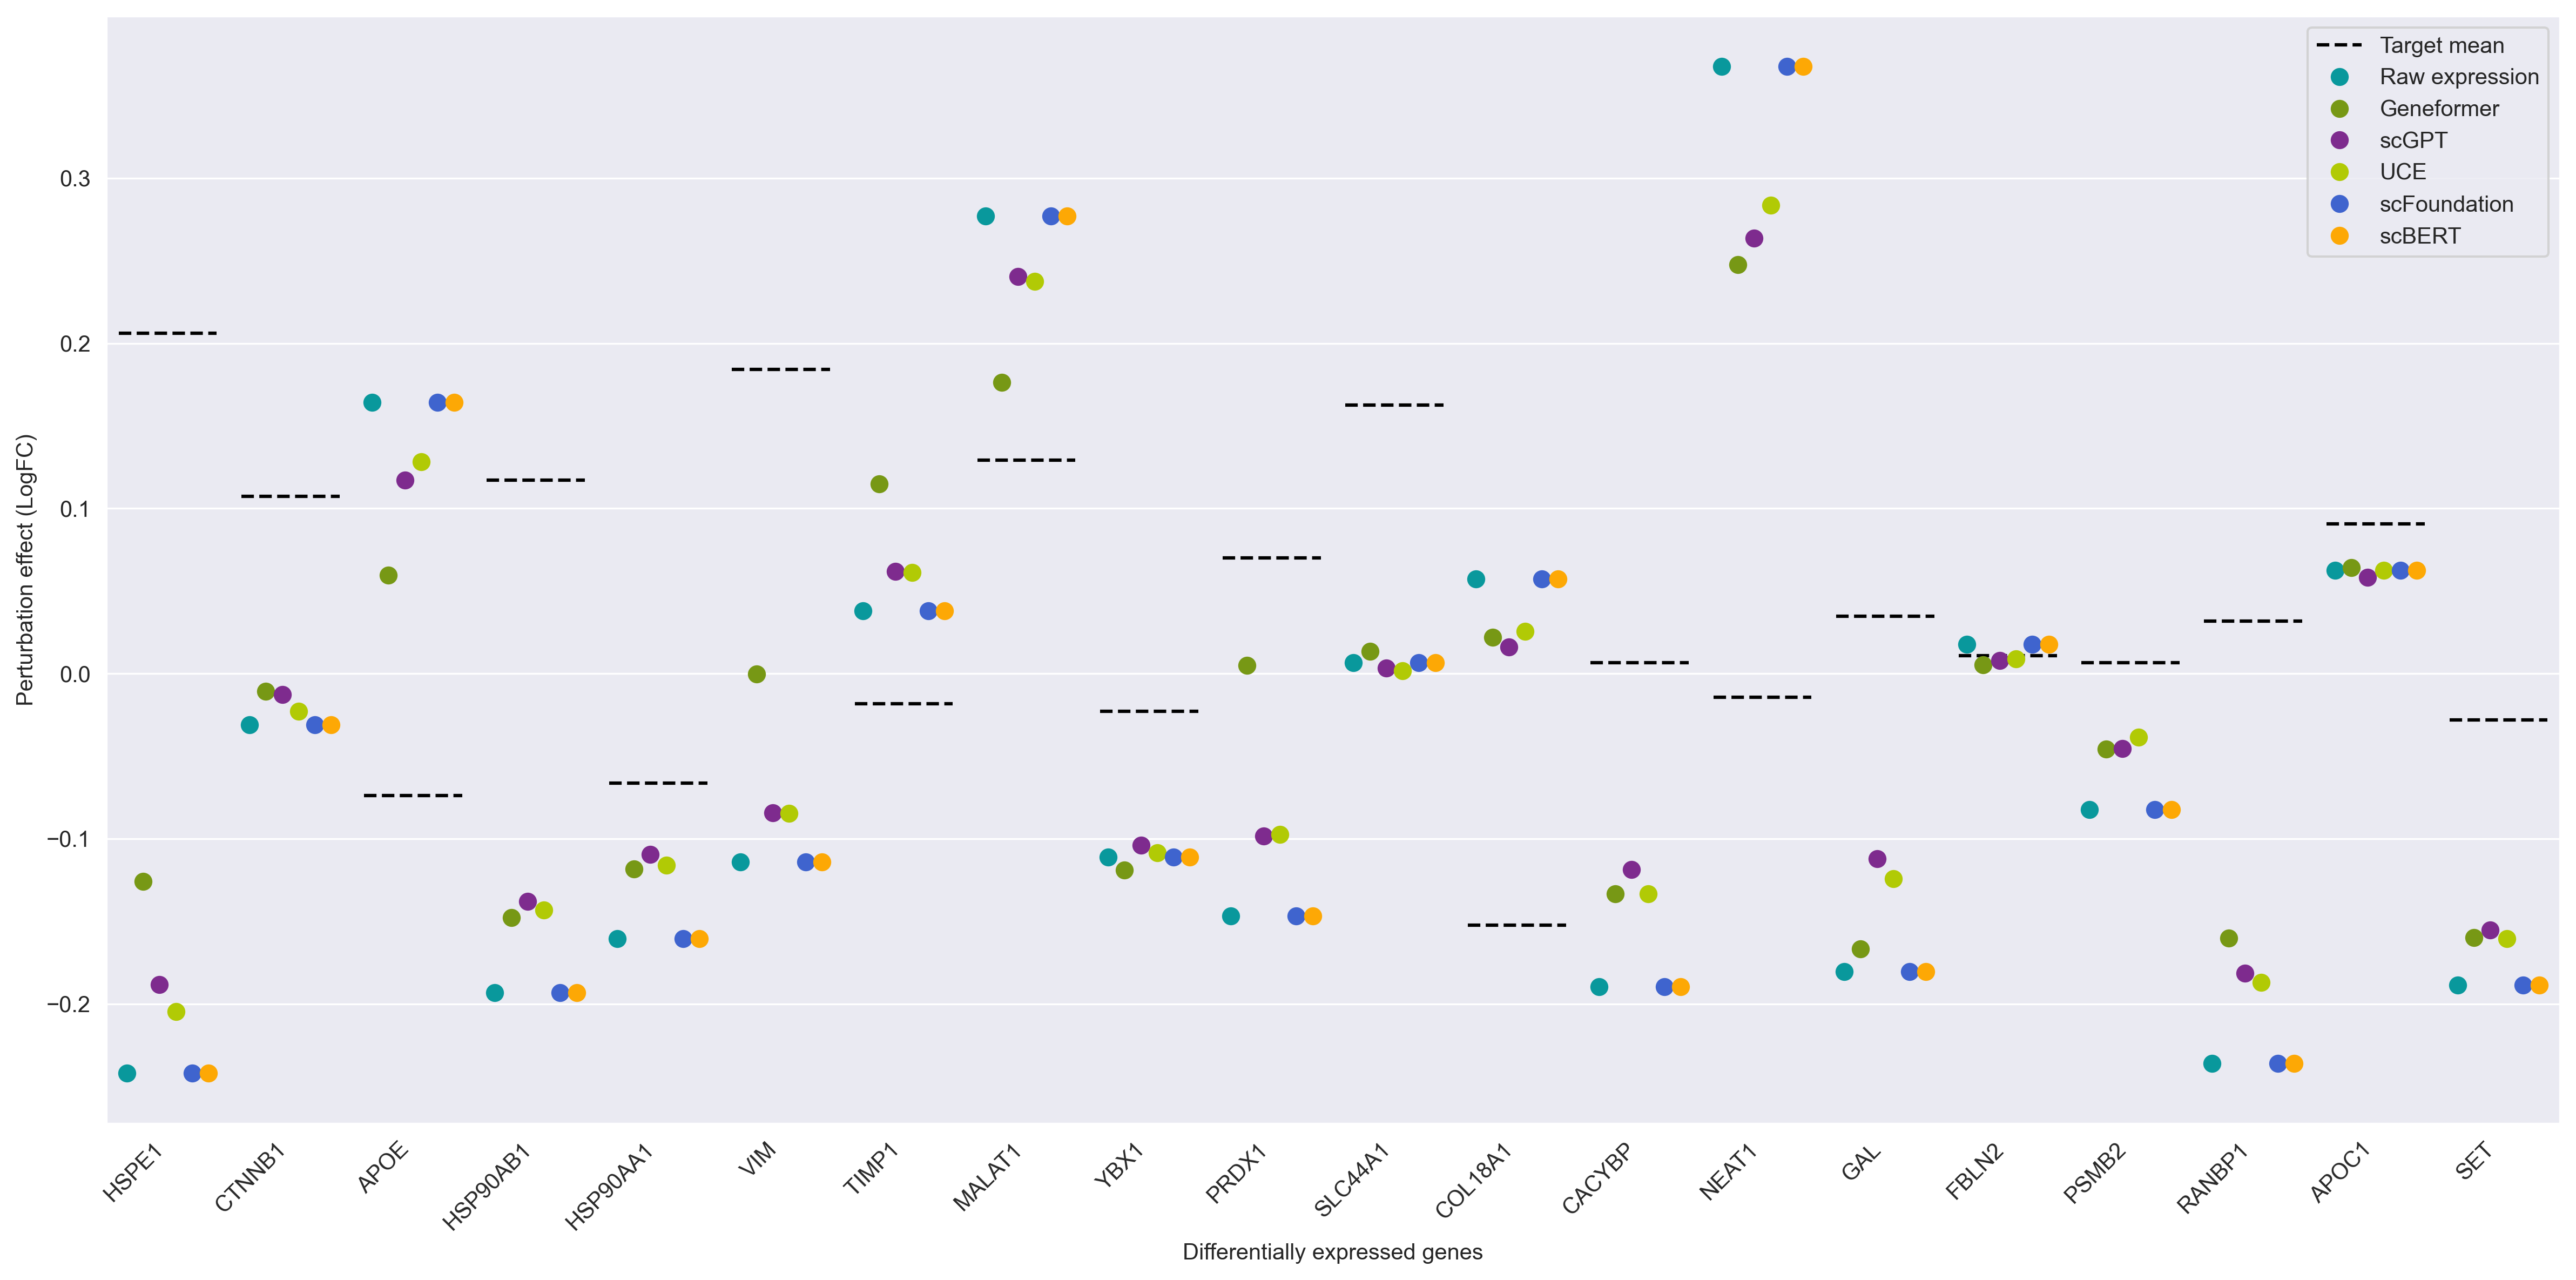

In [64]:
create_swarm_plots(data, deg_dict_symb)